# Windkessel

In [1]:
import numpy as np
import torch

In [2]:
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [4]:
import sys
sys.path.insert(0, './python')

In [5]:
def plot_x_y(x, y, x_label="x", y_label="y"):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x, y)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [6]:
def print_model_params(wk_model):
    print("Параетры модели: ")
    print("R:\t%.2f" % test_model.R)
    print("Z_0:\t%.4f" % test_model.Z_0)
    print("C:\t%.2f" % test_model.C)
    print("P_out:\t%.2f" % test_model.P_out)

In [7]:
from windkessel import model, utils

test_model = model.WindkesselModel()

In [8]:
patient_id = 146300

### Данные о пациенте

In [9]:
data_patients = pd.read_excel(f'data/data_patients.xlsx', index_col="ID")
data_patients = data_patients[data_patients.index.notnull()]
data_patients = data_patients.drop(columns=["дата", "ФИО"])

In [10]:
data_patients.head()

,№,Возраст,Пол,Рост,Вес,ИМТ,ЧСС,E,A,E/A,...,RA СИС,LA СИС,RB САД,LB САД,RA САД,LA САД,RB ДИА,LB ДИА,RA ДИА,LA ДИА
ID,,,,,,,,,,,,,,,,,,,,,
120787.0,61.0,63.0,1.0,184.0,86.0,25.4,90.0,101.0,68.0,1.485294,...,140.0,143.0,104.0,98,103.0,109.0,85.0,85.0,81.0,89.0
122999.0,139.0,67.0,2.0,160.0,65.0,25.4,66.0,78.0,122.0,0.639344,...,184.0,180.0,132.0,124,131.0,122.0,105.0,101.0,94.0,94.0
123101.0,140.0,60.0,1.0,164.0,92.0,34.2,72.0,140.0,NaN,NaN,...,138.0,124.0,114.0,120,124.0,110.0,103.0,107.0,89.0,90.0
123313.0,147.0,31.0,1.0,171.0,86.0,29.5,72.0,112.0,70.0,1.600000,...,153.0,151.0,96.0,97,97.0,100.0,77.0,78.0,74.0,76.0
123645.0,151.0,44.0,1.0,170.0,100.0,34.6,71.0,77.0,61.0,1.262295,...,156.0,141.0,95.0,97,98.0,109.0,80.0,86.0,74.0,77.0


In [11]:
data_patients["SV"] = data_patients["ФВ"] * data_patients["КДО"] / 100.0

In [12]:
print("Сердечный выброс, мл:\t%.1f" % data_patients["SV"][patient_id])

Сердечный выброс, мл:	45.9


### Предобработка

In [13]:
from scipy.integrate import solve_ivp

In [14]:
tp = pd.read_csv(f'data/{patient_id}.csv', header = None, sep = ' ')

In [15]:
# t в секундах, p в мм.рт.ст.
tp = tp.rename({0 :'t', 1: 'p'}, axis = 1)
tp = tp.sort_values(by=['t'])

In [16]:
#Из эксперимента
T = np.array(tp['t'])
P = np.array(tp['p'])

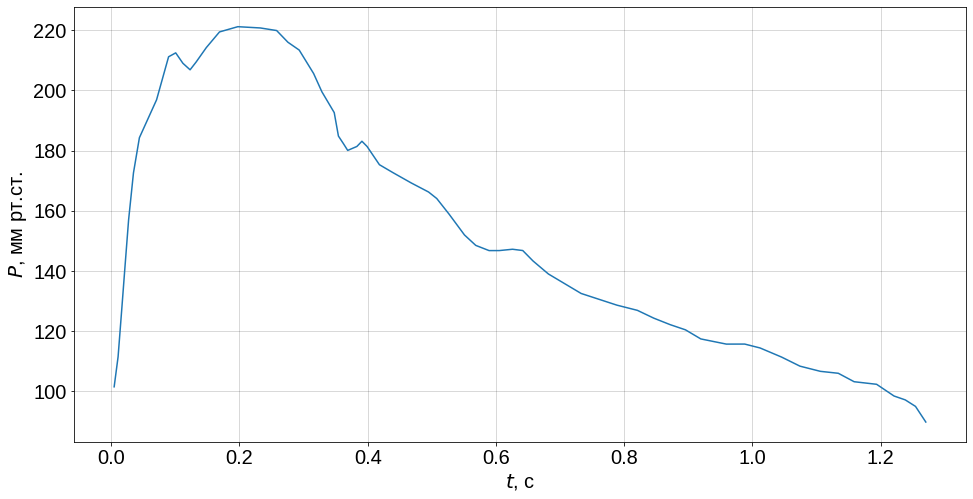

In [17]:
plot_x_y(T, P, "$ t $, с", "$ P $, мм рт.ст.")

#### Сглаживание

In [18]:
# Фильтрация.
n_points = 200
interp1d_params = {}
savgol_filter_params = {"window_length": 9, "polyorder": 3, "mode": "nearest"}

T, P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
        interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)

# Производная.
savgol_filter_params["deriv"] = 1
T, der_P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
        interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)

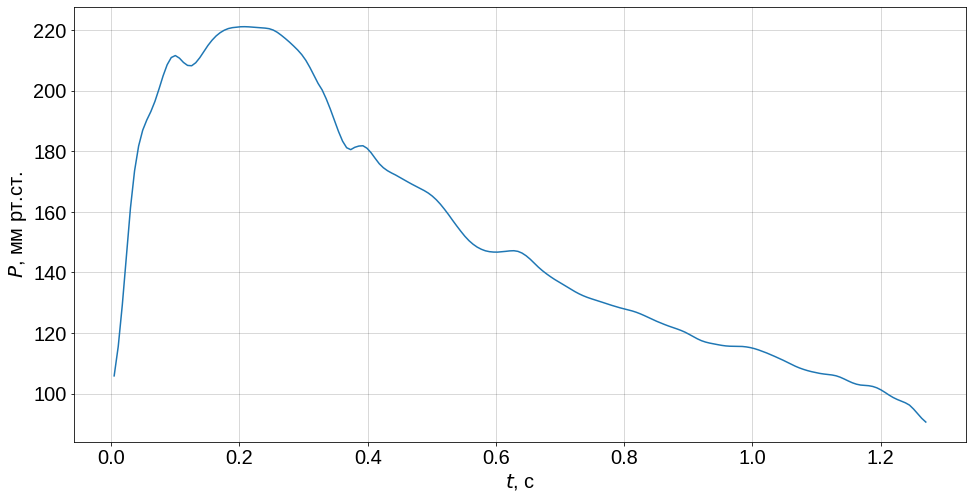

In [19]:
plot_x_y(T, P, "$ t $, с", "$ P $, мм рт.ст.")

In [20]:
test_model.set_P(T, P, der_P)

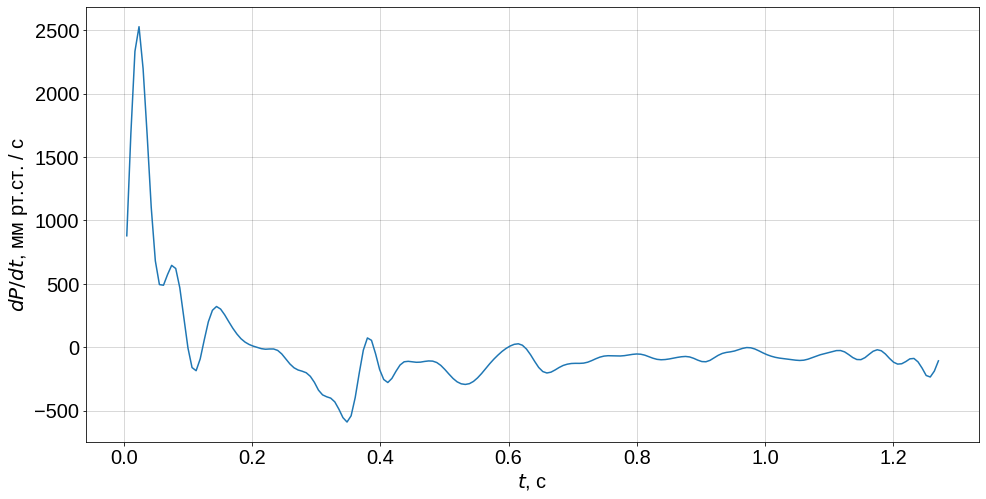

In [21]:
plot_x_y(T, test_model.der_P, "$ t $, с", "$ dP/dt $, мм рт.ст. / с")

#### Получение параметров

In [22]:
P_0, RC, P_out = test_model.get_exp_param()

print("Подобранные параметры: ")
print("P_0:\t%.1f" % P_0)
print("RC:\t%.2f" % RC)
print("P_out:\t%.1f" % P_out)

print()
print("Значение RC по умолчанию: %.2f" % (test_model.R * test_model.C))

Подобранные параметры: 
P_0:	209.5
RC:	1.63
P_out:	0.0

Значение RC по умолчанию: 1.14


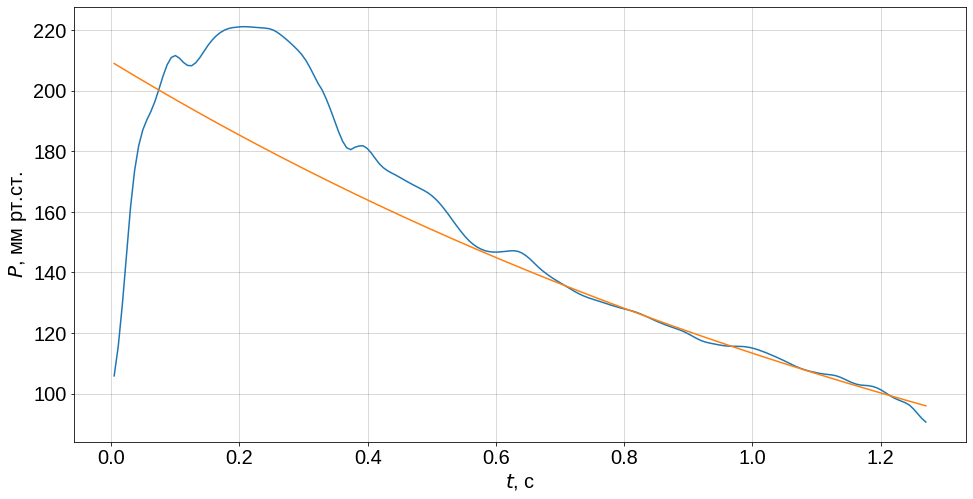

In [23]:
def plot_exp_fit():
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(test_model.T, test_model.P, label="Измеренное давление")
    ax.plot(test_model.T, test_model.diastole_exp_decay(test_model.T, P_0, RC, P_out), label="Экспонента")
    
    ax.set_xlabel("$ t $, с")
    ax.set_ylabel("$ P $, мм рт.ст.")
    
plot_exp_fit()

In [24]:
pulse_pressure = max(P) - min(P)
test_model.C = data_patients["SV"][patient_id] / pulse_pressure
test_model.R = RC / test_model.C

In [25]:
print_model_params(test_model)

Параетры модели: 
R:	4.63
Z_0:	0.0485
C:	0.35
P_out:	33.20


### Получение $ Q_{in}(t) $ по $ P(t) $

In [26]:
def Q_in_rhs(t, Q_in):
    return test_model.Q_in_rhs(t, Q_in)#.detach().numpy()

In [27]:
n_cycles = 2
new_T = np.linspace(T[0], T[0] + n_cycles * (T[-1] - T[0]), n_cycles * (T.shape[0] - 1) + 1)

In [28]:
max_dt = (T[-1] - T[0]) / 100
result = solve_ivp(Q_in_rhs, (new_T[0], new_T[-1]), np.array([0.0]),
                   t_eval=new_T, max_step=max_dt, rtol=1.0)

In [29]:
Q_in = result.y[0]

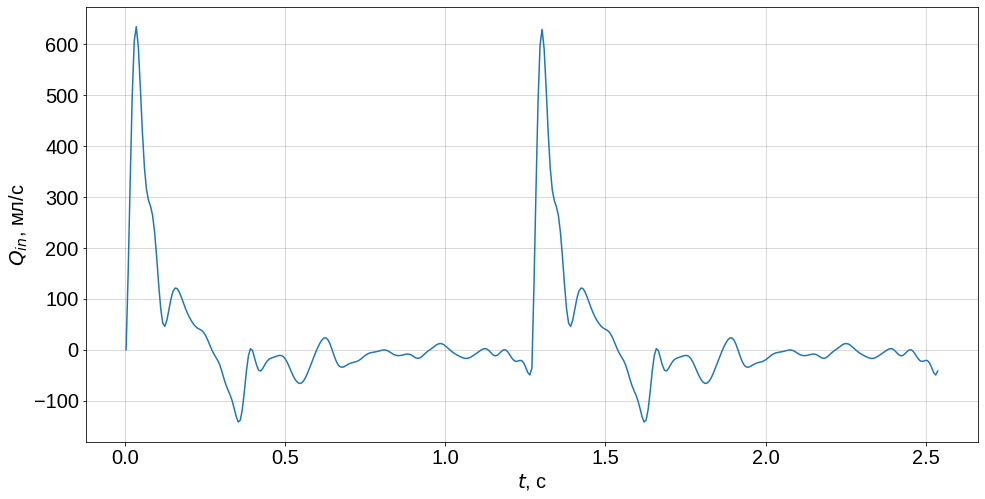

In [30]:
plot_x_y(new_T, Q_in, "$ t $, с", "$ Q_{in} $, мл/с")

In [31]:
from scipy.integrate import simps

def calc_SV(T, Q_in):
    return simps(Q_in, T)

In [32]:
calc_SV(new_T, Q_in) / n_cycles

26.20292533074037

### Подгонка на основе нулевого потока

In [33]:
def zero_Q_in_functional(x):
    #test_model.R, test_model.Z_0, test_model.C, test_model.P_out = x
    #test_model.C, test_model.P_out = x
    test_model.C = x
    test_model.R = RC / test_model.C
    #test_model.R, test_model.C = x
    
    # Получение Q_in.
    result = solve_ivp(Q_in_rhs, (T[0], T[-1]), np.array([0.0]),
                       t_eval=T, max_step=max_dt, rtol=1.0)
    Q_in = result.y[0]
    
    # Получение расчётного времени, начиная с которого поток должен быть нулевым.
    eds_index, eds_time = test_model.get_exp_decay_start()
    
    # Значение функционала.
    _SV = calc_SV(T, Q_in)
    value = (np.mean(np.abs(Q_in[eds_index:])) * (T[1] - T[0]))**2 + (_SV - data_patients["SV"][patient_id])**2
    # + 0.1 * (test_model.R - 0.5)**2
    
    return value

In [34]:
from scipy.optimize import minimize

In [35]:
#x0 = (test_model.R, test_model.Z_0, test_model.C, test_model.P_out)
#x0 = (test_model.R, test_model.C)
x0 = (test_model.C)
minimize(zero_Q_in_functional, x0=x0)

      fun: 0.011222343759369535
 hess_inv: array([[8.45304116e-05]])
      jac: array([2.73343176e-07])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.60299651])

In [36]:
result = solve_ivp(Q_in_rhs, (new_T[0], new_T[-1]), np.array([0.0]),
                   t_eval=new_T, max_step=max_dt, rtol=1.0)

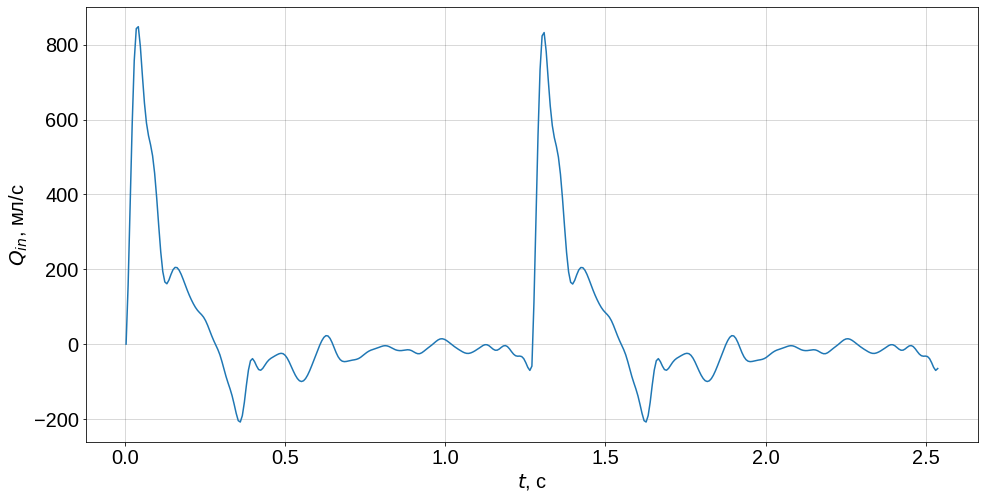

In [37]:
Q_in = result.y[0]

plot_x_y(new_T, Q_in, "$ t $, с", "$ Q_{in} $, мл/с")

In [38]:
calc_SV(new_T, Q_in) / n_cycles

44.95637515509617

In [39]:
print_model_params(test_model)

Параетры модели: 
R:	2.70
Z_0:	0.0485
C:	0.60
P_out:	33.20
